In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import plotly.express as px
# https://www.python-graph-gallery.com/

In [3]:
# https://plotly.com/python/choropleth-maps/


df = px.data.gapminder().query("year==2007")
fig = px.choropleth(df, locations="iso_alpha",
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

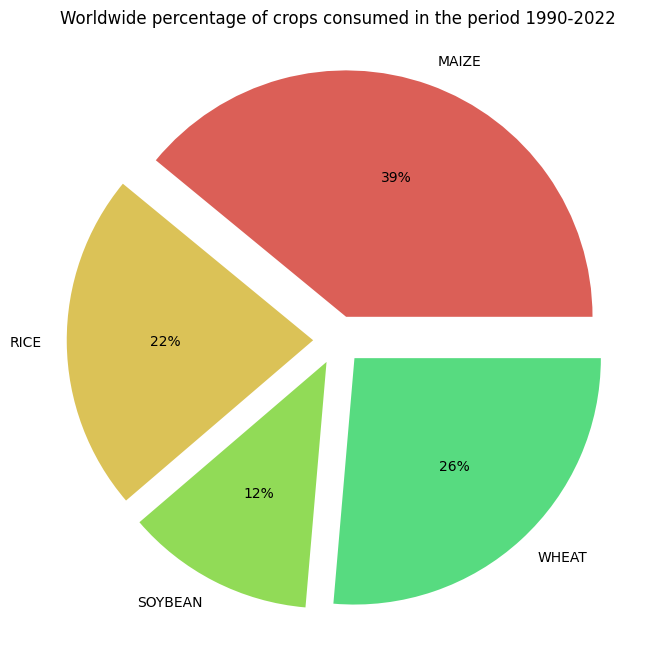

In [13]:
wcrop = pd.read_csv('datasets/worldwide_crop_consumption.csv')
wcrop.head()
# 0,1,,2,3...  LOCATION, SUBJECT, MEASURE, TIME, Value
wcrop['SUBJECT'].unique()
wcrop['LOCATION'].unique()

#wcrop['timeint'] = wcrop["TIME"].astype('int32')
wcropNow = wcrop.query("TIME < 2023")

#each crop ha a different measure unit, just choose one
#TONNE_HA, THND_TONNE, THND_HA
# df2=df.loc[(df['Discount'] >= 1200) | (df['Fee'] >= 23000 )]
wcropNow.drop(wcropNow.loc[(wcropNow['MEASURE'] == 'THND_HA') | (wcropNow['MEASURE'] == 'TONNE_HA')].index, axis=0, inplace=True)

minyear = wcropNow['TIME'].min()
maxyear = wcropNow['TIME'].max()


# MAP OF QUANTITY OF CROP CONSUMED ALL TIME, FROM 1990 TO 2022

consalltime = wcropNow.groupby('LOCATION').sum()
wldalltime = consalltime.loc["WLD", "Value"]

consalltime.drop("WLD", axis=0, inplace=True)
consalltime.drop("BRICS", axis=0, inplace=True)
consalltime.drop("OECD", axis=0, inplace=True)
consalltime.drop("EU28", axis=0, inplace=True)

vmin = consalltime.Value.min()
vmax = consalltime.Value.max()

fig = px.choropleth(consalltime, locations=consalltime.index,
                    color="Value", # lifeExp is a column of gapminder
                    hover_name=consalltime.index, # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
                    #color_continuous_scale=[(0, "red"), (0.5, "green"), (1, "blue")]
                    #color_continuous_scale=px.colors.diverging.BrBG
                    #color_continuous_scale='Bluered_r'
fig.show()

# PERCENTAGE OF CONSUMED CROPS WORLDWIDE

wcropNow['SUBJECT'].unique() # ['RICE', 'WHEAT', 'SOYBEAN', 'MAIZE']

cropPerc = wcropNow.drop(wcropNow.loc[(wcropNow['LOCATION'] == 'WLD')].index, axis=0, inplace=False).drop(wcropNow.loc[(wcropNow['LOCATION'] == 'EU28')].index, axis=0, inplace=False).drop(wcropNow.loc[(wcropNow['LOCATION'] == 'BRICS')].index, axis=0, inplace=False).drop(wcropNow.loc[(wcropNow['LOCATION'] == 'OECD')].index, axis=0, inplace=False)

cropPerc = cropPerc.groupby(by='SUBJECT').sum()
cropPerc['perc'] = cropPerc['Value'] / cropPerc['Value'].sum()
cropPerc.reset_index(inplace=True)

plt.figure(figsize=(12, 8))

plt.pie(cropPerc['perc'], labels = cropPerc['SUBJECT'], colors= sns.color_palette("hls", 8), autopct='%.0f%%', explode=(0.1,0.1,0.1,0.1))

plt.title("Worldwide percentage of crops consumed in the period 1990-2022")

plt.show()

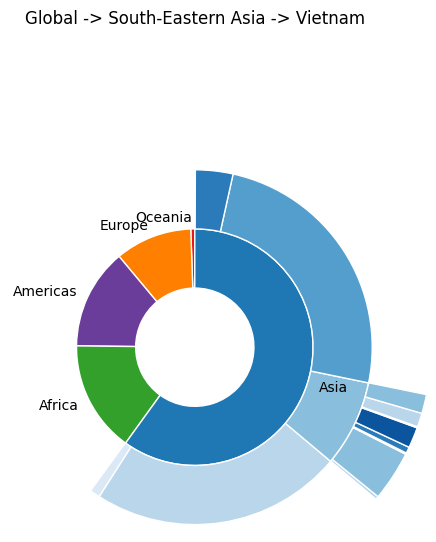

In [14]:
wd = pd.read_csv("datasets/world_data.csv", sep=";")
#print(wd.head())
# region, subregion, key, value

# remove nans
wd.drop(wd[wd["value"] == -1].index, axis=0, inplace=True)

regSum = wd.groupby(by="region").sum()
regSum.reset_index(inplace=True)
regSum['perc'] = regSum['value'] / regSum.value.sum()
regSum.sort_values(by="perc", inplace=True)
regSum.reset_index(inplace=True)


#print(wd['subregion'].unique())
# Southern Asia, South-Eastern Asia
wd[wd["subregion"] == "South-Eastern Asia"] # (9,4)
# Western Asia, 
#subrSum1 = wd.query("subregion == 'Southern Asia' | subregion == 'Southern Asia' | subregion == 'Eastern Asia'")
#column_name.str.contains("abc")
subr1 = wd.query("subregion.str.contains('Asia')", engine="python")
subr1.subregion.unique() # ['Southern Asia', 'Western Asia', 'South-Eastern Asia', 'Eastern Asia', 'Central Asia']

subr1 = subr1.groupby(by="subregion").sum()
#subr1['perc'] = subr1.value / subr1.value.sum()
subr1['perc'] = subr1.value / regSum.value.sum()


subr1.reset_index(inplace=True)

key = wd.query("subregion == 'South-Eastern Asia'")
#key['perc'] = key.value / key.value.sum()
key['perc'] = key.value / regSum.value.sum()
key.reset_index(inplace=True)

keylabels = [ f"{str(a)} {str(b*100)[:4]}" for (a,b) in zip(key.key, key.perc)]

#now plot concetric donuts
fig, ax = plt.subplots()

rad= 1.6
size = 0.4
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

textprops = {"fontsize":8,'color':'black'}

ax.pie(regSum.perc, radius=rad-2*size, colors=['#e31a1c', '#ff7f00', "#6a3d9a",'#33a02c', '#1f78b4' ], labels=regSum.region,
       startangle=90, frame = True,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(subr1.perc, radius=rad-size, colors=sns.color_palette("Blues"),
       wedgeprops=dict(width=size, edgecolor='w'),
      normalize=False, startangle=234
      )

ax.pie(key.perc, radius=rad, 
       wedgeprops=dict(width=size, edgecolor='w'),
       textprops=textprops,
       startangle=-40,
      normalize=False,
      colors=sns.color_palette("Blues"))

ax.set(aspect="equal")
plt.title("Global -> South-Eastern Asia -> Vietnam", loc="center", pad=100)
plt.show()



In [49]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.manifold import MDS
import umap.umap_ as umap

In [61]:
pc = pd.read_csv("datasets/setlur.csv", sep="\t")
pc = pc.T
pc.columns = pc.iloc[0]
pc.drop(pc.index[0], inplace=True)

# 208404 to 208512 are swedish
pc['nation'] = [ "Sweden"  if int(x[3:]) >= 208404 and int(x[3:]) <= 208512 else "America" for x in pc.index]
# 1 prostate fusion, 0 prostate no fusion
pc['y'] = [ f"Prost_fus_{y}" if int(x) == 1 else  f"Prost_no_fus_{y}" if int(x) == 0 else f"unknown_{y}"  for x, y in zip(pc.Label, pc.nation)]

data_subset = pc.iloc[:, :-3]

In [62]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

pc['pca-one'] = pca_result[:, 0]
pc['pca-two'] = pca_result[:, 1] 
pc['pca-three'] = pca_result[:, 2]

mds_res = MDS(n_components=2, metric=False, normalized_stress='auto').fit_transform(data_subset)

pc['mds0'] = mds_res[:,0]
pc['mds1'] = mds_res[:,1]

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

pc['tsne-2d-one-p10'] = tsne_results[:, 0]
pc['tsne-2d-two-p10'] = tsne_results[:, 1]

embedding = umap.UMAP(n_neighbors=5, random_state=42).fit(data_subset).transform(data_subset)

pc['umap0-n5'] = embedding[:, 0]
pc['umap1-n5'] = embedding[:, 1]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 472 samples in 0.001s...
[t-SNE] Computed neighbors for 472 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 472 / 472
[t-SNE] Mean sigma: 7.061498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.367134
[t-SNE] KL divergence after 300 iterations: 1.872098


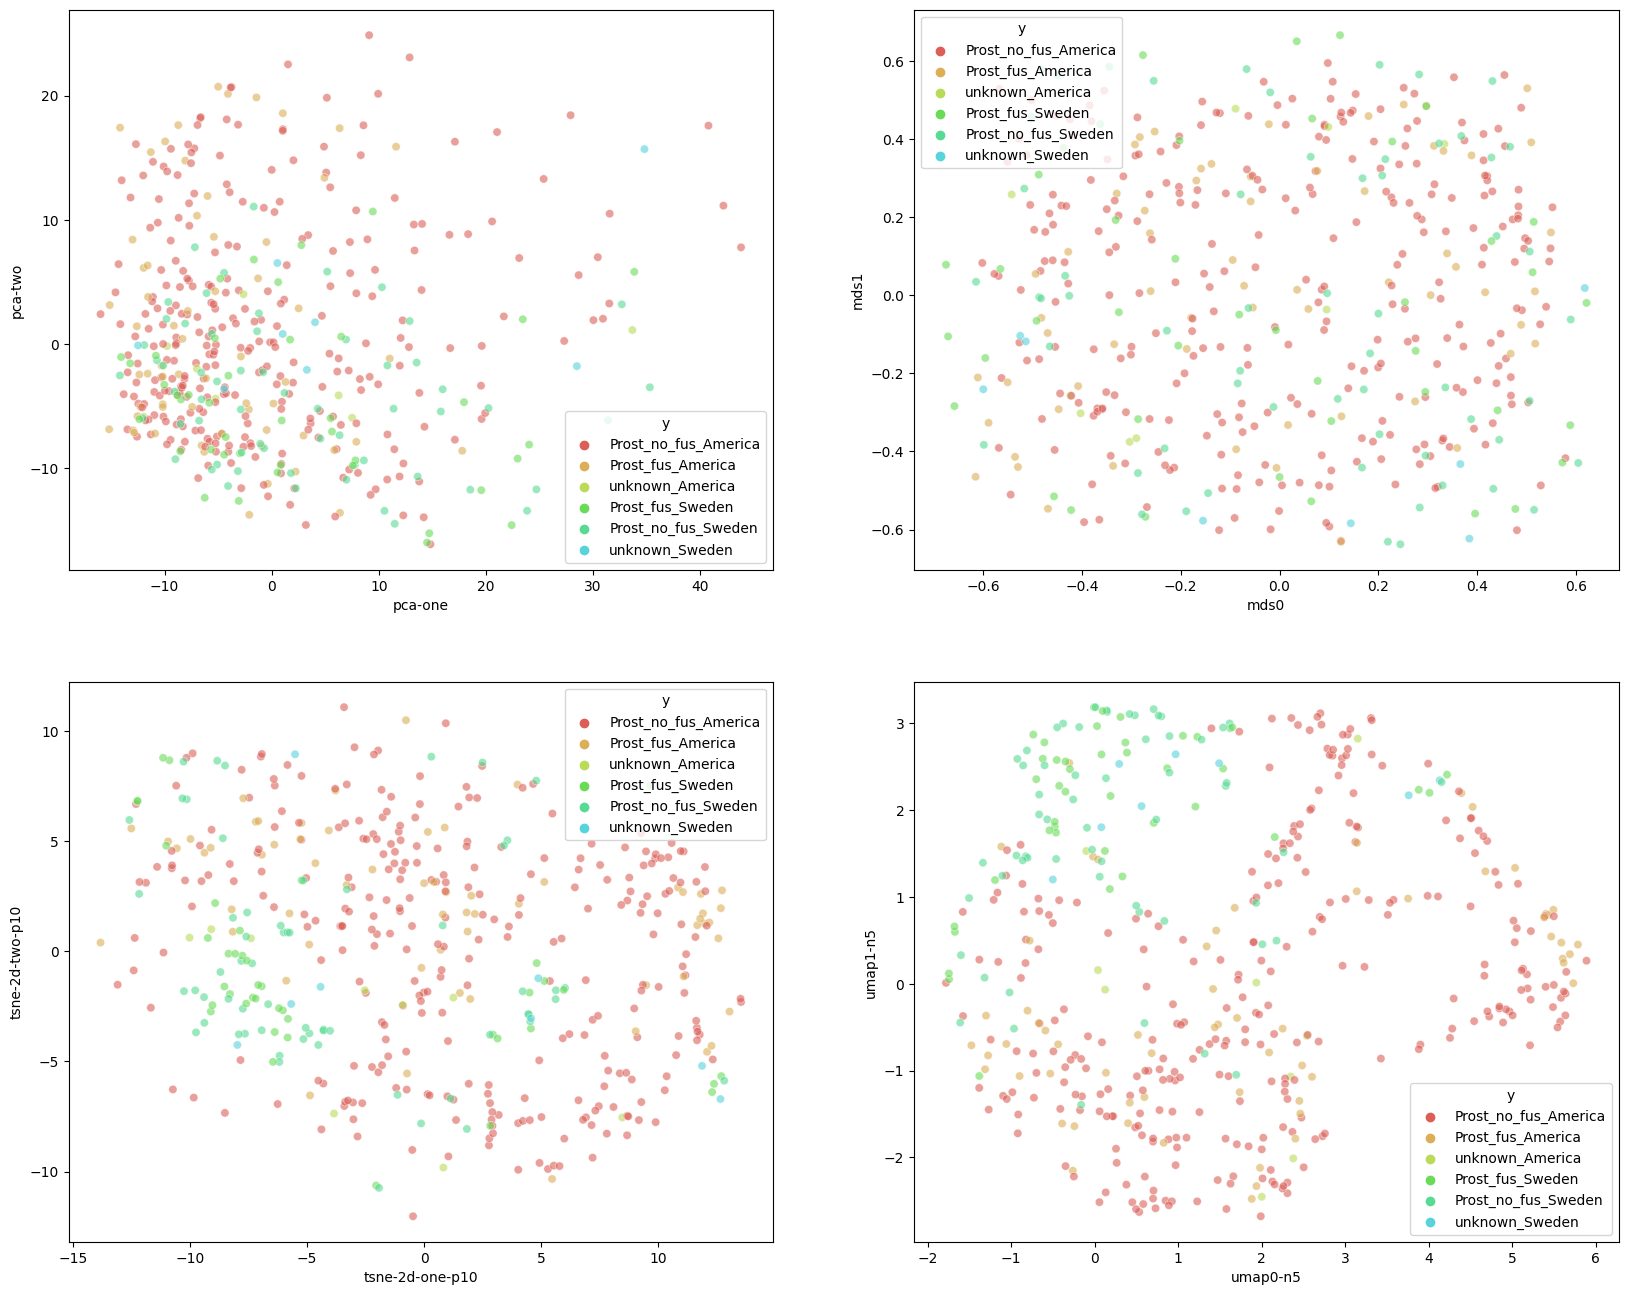

In [63]:
plt.figure(figsize=(20, 16))

ax1 = plt.subplot(2, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax1
)

ax2 = plt.subplot(2, 2, 2)
sns.scatterplot(
    x="mds0", y="mds1",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax2
)

ax3 = plt.subplot(2, 2, 3)
sns.scatterplot(
    x="tsne-2d-one-p10", y="tsne-2d-two-p10",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax3
)


ax4 = plt.subplot(2, 2, 4)
sns.scatterplot(
    x="umap0-n5", y="umap1-n5",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax4
)

plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 472 samples in 0.002s...
[t-SNE] Computed neighbors for 472 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 472 / 472
[t-SNE] Mean sigma: 9.934424
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.971577
[t-SNE] KL divergence after 300 iterations: 1.096543
[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 472 samples in 0.002s...
[t-SNE] Computed neighbors for 472 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 472 / 472
[t-SNE] Mean sigma: 10.692302
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.080673
[t-SNE] KL divergence after 300 iterations: 0.920474


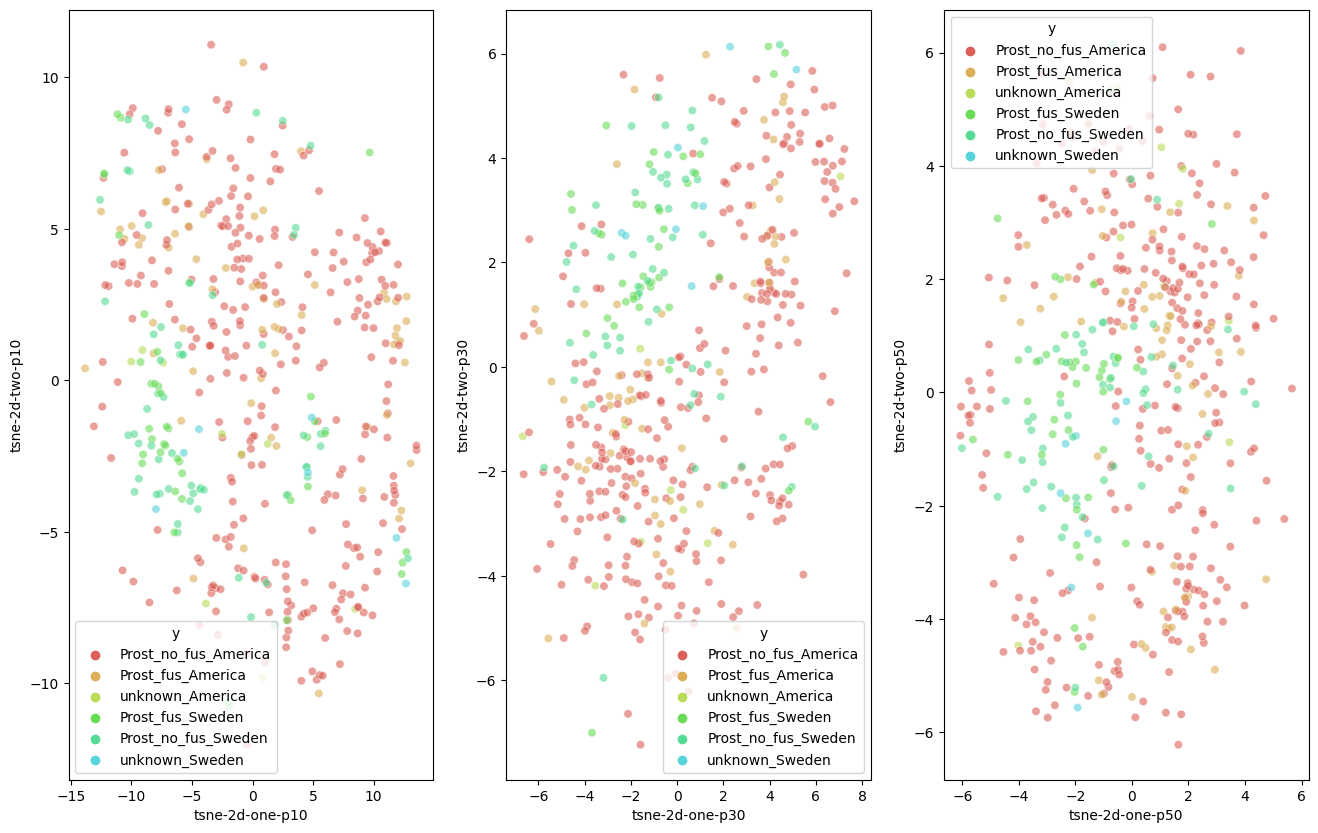

In [65]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

pc['tsne-2d-one-p30'] = tsne_results[:, 0]
pc['tsne-2d-two-p30'] = tsne_results[:, 1]

tsne = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

pc['tsne-2d-one-p50'] = tsne_results[:, 0]
pc['tsne-2d-two-p50'] = tsne_results[:, 1]


plt.figure(figsize=(16, 10))

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="tsne-2d-one-p10", y="tsne-2d-two-p10",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax1
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one-p30", y="tsne-2d-two-p30",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-2d-one-p50", y="tsne-2d-two-p50",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax3
)

plt.show()


In [66]:
embedding = umap.UMAP(n_neighbors=15, random_state=42).fit(data_subset).transform(data_subset)

pc['umap0_n15'] = embedding[:, 0]
pc['umap1_n15'] = embedding[:, 1]

embedding = umap.UMAP(n_neighbors=30, random_state=42).fit(data_subset).transform(data_subset)

pc['umap0_n30'] = embedding[:, 0]
pc['umap1_n30'] = embedding[:, 1]

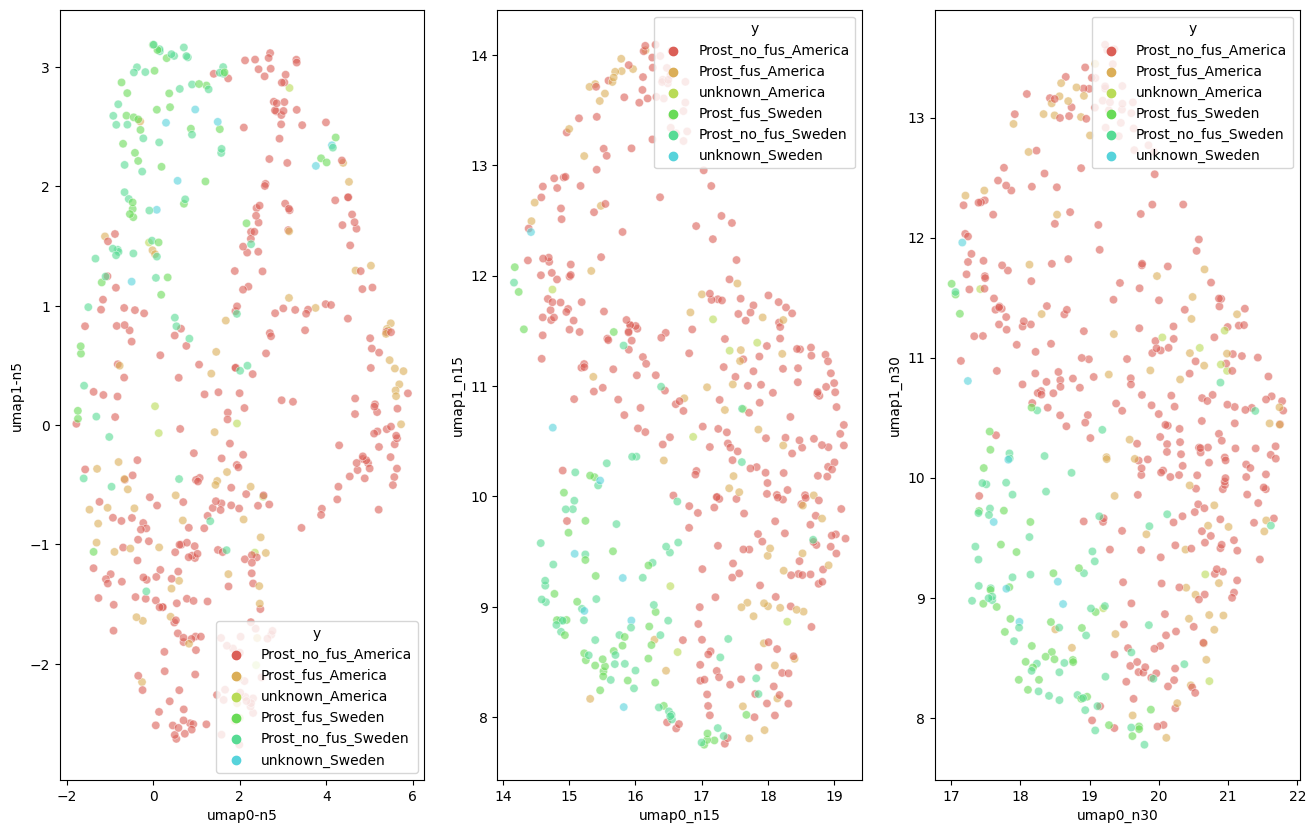

In [67]:
plt.figure(figsize=(16, 10))

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="umap0-n5", y="umap1-n5",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax1
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="umap0_n15", y="umap1_n15",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="umap0_n30", y="umap1_n30",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pc,
    legend="full",
    alpha=0.6,
    ax=ax3
)

plt.show()
